<a href="https://colab.research.google.com/github/01PrathamS/DCAI_Practice/blob/main/lab_4_data_centric_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cleanlab

In [73]:
import pandas as pd
import numpy as np
import sklearn

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
SEED = 123
np.random.seed(SEED)

In [75]:
df = pd.read_csv('/content/train_dcai_evaluation.csv')
df_test = pd.read_csv('/content/train_dcai_evaluation.csv')

In [76]:
df.head()

x0        x1        x2        x3        x4     x5  y
0 -0.333489 -0.770208 -2.697486 -0.628563 -1.277720  100.0  2
1 -0.787124  1.230800  1.415472 -0.805927  0.175115  100.0  1
2  0.781197 -0.856227  2.138879  2.495417  0.868192  100.0  1
3  1.895093 -0.885939  1.946352 -2.082747  0.064914  100.0  1
4  0.689091 -5.091299 -2.218682  0.330767  3.012755  100.0  2

In [77]:
df.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'y'], dtype='object')

In [78]:
df.y.value_counts ()

1    1856
2    1836
0     178
Name: y, dtype: int64

In [79]:
y = df["y"].values
df.drop(columns=["y"], inplace=True)
X = df.values

y_test = df_test["y"].values
df_test.drop(columns=["y"], inplace=True)
X_test = df_test.values

print(X)
print(y)

[[  -0.33348927   -0.7702077    -2.69748604   -0.62856274   -1.27772042
   100.        ]
 [  -0.7871239     1.23080016    1.41547226   -0.8059272     0.1751147
   100.        ]
 [   0.78119711   -0.85622725    2.13887864    2.49541712    0.86819164
   100.        ]
 ...
 [   1.19101444   -1.72465036   -1.17854745   -1.54881816   -1.51740071
  -100.        ]
 [  -2.03358571   -0.23977122    1.21509471    0.86023614    0.69816843
   100.        ]
 [   0.15125519   -1.21711969    2.77498591    0.7090941     0.89159205
  -100.        ]]
[2 1 1 ... 2 1 1]


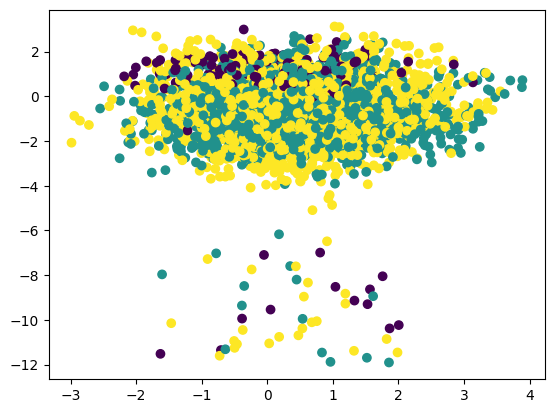

In [80]:
plt.scatter(X[:,0], X[:,1], c=list(y))

## Improve ML model via data-centric techniques

In [81]:
def train_model(X, y, X_test, y_test):
  model = MLPClassifier(early_stopping=True, random_state=SEED)
  model.fit(X, y)
  predictions = model.predict(X_test)
  acc = balanced_accuracy_score(y_true=y_test, y_pred=predictions)
  print(f"Balanced Accuracy = {acc}")
  return predictions

In [82]:
predictions = train_model(X, y, X_test, y_test)

Balanced Accuracy = 0.5791043660350188


In [83]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

matrix = confusion_matrix(y_test, predictions)
print(confusion_matrix)
print(f"Per-class accuracies: {matrix.diagonal()/matrix.sum(axis=1)}")
print(precision_score(y_test, predictions, average='weighted'))
print(recall_score(y_test, predictions, average='weighted'))

<function confusion_matrix at 0x790f0097af80>
Per-class accuracies: [0.00561798 0.88038793 0.85130719]
0.8353634851519411
0.8263565891472868


In [89]:
# ## Completely removed the class which has minimal number of instances.

# dataset = pd.read_csv('/content/train_dcai_evaluation.csv')
# dataset = dataset[dataset['y'] != 0]
# dataset.y.value_counts()

# dataset_test = pd.read_csv('/content/train_dcai_evaluation.csv')
# dataset_test = dataset[dataset['y'] != 0]
# dataset_test.y.value_counts()

# train_model(dataset.drop('y', axis=1), dataset.y, dataset_test.drop('y', axis=1), dataset_test.y )    ## Balanced Accuracy = 0.8675631291788746

Balanced Accuracy = 0.8675631291788746


array([2, 1, 1, ..., 2, 1, 1])

In [85]:
# ## Evaluating model by doing standardization on data

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(X)
# x_test_scaled = scaler.fit_transform(X_test)

# train_model(x_train_scaled, y, x_test_scaled, y_test)  ## Balanced Accuracy = 0.5844249792559841

In [86]:
# ## Evaluating model by doing normalizing on data

# from sklearn.preprocessing import MinMaxScaler

# min_max_scaler = MinMaxScaler()
# x_train_scaled = min_max_scaler.fit_transform(X)
# x_test_scaled = min_max_scaler.fit_transform(X_test)

# train_model(x_train_scaled, y, x_test_scaled, y_test)   ## Balanced Accuracy = 0.5747134262389503

In [99]:
from cleanlab.outlier import OutOfDistribution
rare_class=0
# n_outlier = 100  # try different values to determine good one
for n_outlier in range(20, 150, 20):
  knn = sklearn.neighbors.NearestNeighbors(n_neighbors=10).fit(X)
  ood = OutOfDistribution({"knn": knn})
  ood_scores = ood.score(features=X)
  outlier_examples = np.argsort(ood_scores)[:n_outlier]
  outlier_examples = [out for out in outlier_examples if y[out] != rare_class]  # do not delete rare-class examples

  X = np.delete(X, outlier_examples, axis=0)
  y =  np.delete(y, outlier_examples)
  print(f'for {n_outlier} balanced accuracy is:{predictions = train_model(X, y, X_test, y_test)}')


Balanced Accuracy = 0.8137517851178814


In [103]:

n_upsample = 10

rareclass_X = X[y == rare_class,:]
for n in range(n_upsample):
    X = np.concatenate((X, rareclass_X + 0.001*np.random.rand(rareclass_X.shape[0],rareclass_X.shape[1])))

y = np.concatenate((y, np.array([rare_class]*int(n_upsample*np.sum(y==rare_class)))))


len before upsampling: 2607710
len after upsampling: 28668690


In [ ]:
train_model(X, y, X_test, y_test)

## One variant of this is to train a separate model on just the subgroup where our original model underperforms and then ensemble the two models

## some data may not have obvious slices, for example a coleection of documents or images, how can we identify subgroups where our model underforms?

1. sort examples in the validation data by their loss value, and look at the example with high loss for which your model is making the worst predictions (Error Analysis)

2. Apply clustering to these examples with high loss to uncover clusters that share common themes amongst these examples


### To catch outliers encountered during deployment, include Out-of-Distribution in your ML pipeline